**Import libraries**

In [111]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from matplotlib.colors import to_rgb, to_hex
import seaborn as sns
import numpy as np

**This ipynb is used to process and analyze data from an experiment involving AAVrg and cFos in two conditions:**

"10 minutes familiar" (n=5) ***full_focus1*** 

"cagemate" (n=3) ***full_focus2***

The data is stored in an Excel file with two sheets: full_focus1 and full_focus2. This code performs data cleaning, mapping, and organization to prepare the data for further analysis.

In [112]:
# Load the Excel file
file_path = r"C:\Users\sjs93\Downloads\cell_counts_full (2).xlsx"
excel_file = pd.ExcelFile(file_path)

# Load both sheets into separate DataFrames
sheet1 = pd.read_excel(file_path, sheet_name='full_focus1')
sheet2 = pd.read_excel(file_path, sheet_name='full_focus2')

# Rename columns for consistency
sheet1.columns = ["Slice", "Count", "Total Area", "Average Size", "%Area", "Mean", "Perim.", "Threshold"]
sheet2.columns = ["Slice", "Count", "Total Area", "Average Size", "%Area", "Mean", "Perim.", "Threshold"]

# Drop the 'Threshold' column
sheet1 = sheet1.drop(columns=['Threshold', 'Total Area', "Average Size", "%Area", "Mean", "Perim."])
sheet2 = sheet2.drop(columns=['Threshold', 'Total Area', "Average Size", "%Area", "Mean", "Perim."])

sheet1['Slice'] = sheet1['Slice'].str.lower()
sheet2['Slice'] = sheet2['Slice'].str.lower()

# Define subject-specific mappings for Channel in full_focus1 = 10 mins fam condition 
subject_mappings_full_focus1 = {
    '2_1': {'gfp': 'NAc', 'mcherry': 'MD'},
    '2_2': {'gfp': 'NAc', 'mcherry': 'MD'},
    '2_3': {'gfp': 'NAc', 'mcherry': 'MD'},
    '1_2': {'gfp': 'MD', 'mcherry': 'NAc'},
    '1_3': {'gfp': 'MD', 'mcherry': 'NAc'}
}

# Define the default mapping for full_focus2 = cagemate condition 
default_mapping_full_focus2 = {'gfp': 'MD', 'mcherry': 'NAc'}


# Function to extract markers from Slice and create projector label
def create_projector(slice_value, subject, sheet_name):
    markers = []
    if 'cfos' in slice_value:
        markers.append('cfos')
    if 'gfp' in slice_value:
        markers.append('gfp')
    if 'mcherry' in slice_value:
        markers.append('mcherry')

    if sheet_name == 'full_focus1' and subject in subject_mappings_full_focus1:
        region_mapping = subject_mappings_full_focus1[subject]
    else:
        region_mapping = default_mapping_full_focus2

    combined_markers = []
    for marker in markers:
        if marker in ['gfp', 'mcherry']:
            region = region_mapping.get(marker, 'Unknown')
            combined_markers.append(region)
        else:
            combined_markers.append(marker)
    
    # Sort combined markers alphabetically to ensure consistent ordering
    combined_markers.sort()
    
    return '+'.join(combined_markers) + '+'

# Function to extract the subject number from the Slice column
def extract_subject(slice_value):
    parts = slice_value.split('_')
    if len(parts) >= 3:
        return parts[1] + '_' + parts[2]  # Assuming the subject number is in the 2nd and 3rd position
    return 'Unknown'  # In case the slice format is unexpected

# Function to extract the region information from the Slice column
def extract_region(slice_value):
    parts = slice_value.split('_')
    if len(parts) >= 4:
        return parts[3]  # Assuming the region information is in the 4th position
    return 'Unknown'  # In case the slice format is unexpected

# Process the data for both sheets
def process_data(df, sheet_name):
    df['Slice'] = df['Slice'].astype(str)
    df['Subject'] = df['Slice'].apply(extract_subject)  # Extract the subject number
    df['Region'] = df['Slice'].apply(extract_region)    # Extract the region information
    df['Projector'] = df.apply(lambda row: create_projector(row['Slice'], row['Subject'], sheet_name), axis=1)
    return df

# Apply the updated function to both sheets. sheet1_processed = 10 min fam, sheet2_processed = cagemate 
sheet1_processed = process_data(sheet1, 'full_focus1')
sheet2_processed = process_data(sheet2, 'full_focus2')

# Preprocessing Base Region Columns:
# The 'Region' column in both `sheet1_processed` and `sheet2_processed` DataFrames contains region strings.
# Assume each region string starts with an unnecessary prefix character (e.g., a code identifier),
# that you want to remove to make the 'Region' more readable or standardize formatting.

# The `.apply()` function here applies a lambda function to each element of the 'Region' column:
# `lambda x: x[1:]` - This lambda function takes each string `x` and slices it from the second character to the end.
# This effectively removes the first character of each string.

# The resulting series (after removal of the first character from each region string) 
# directly replaces the original 'Region' values in a new column called 'Base region':
sheet1_processed['Base region'] = sheet1_processed['Region'].apply(lambda x: x[1:])
sheet2_processed['Base region'] = sheet2_processed['Region'].apply(lambda x: x[1:])

# After execution, both DataFrames will have a new column 'Base region' 
# which contains the modified region strings with the first character removed.


Aggregating and Combining Data from Two Sheets

Objective:

This script aims to aggregate data based on specific categories from two distinct sheets, and it subsequently consolidates the results for a comprehensive comparison or analysis.

Steps and Explanation:

1. Grouping and Summing Data from sheet1_processed:

Group by Multiple Columns: Apply the .groupby() function on 'Projector', 'Subject', and 'Base region' which groups the data appropriately.

Aggregate: For each group, calculate the sum of the 'Count' column using ['Count'].sum(), which provides the total counts for each category.

Reset Index: The index is reset to ensure it's properly formatted and easy to read post-grouping.
Assign a New Column: We use .assign(sheet='full_focus1') to add a new column that indicates which sheet the data came from.

In [113]:
# Grouping data in sheet1:
# `groupby(['Projector', 'Subject', 'Base region'])` 
# This groups the data in the dataframe `sheet1_processed` by the columns 'Projector', 'Subject', and 'Base region'.

# `['Count'].sum()` 
#  For each group, it calculates the sum of the 'Count' column which represents the aggregated count.

# `reset_index()` - Resets the index of the DataFrame to the default integer index.

# `assign(sheet='full_focus1')` 
# Adds an additional column named 'sheet' which contains the sheet identifier 'full_focus1' for each row,
# helping to identify from which sheet (or focus) the data originated.
sheet1_grouped = sheet1_processed.groupby(['Projector', 'Subject', 'Base region'])['Count'].sum().reset_index().assign(sheet='full_focus1')

# Similar operations are performed on sheet2:
# Following the same steps as for sheet1 but results are marked with 'full_focus2'.
sheet2_grouped = sheet2_processed.groupby(['Projector', 'Subject', 'Base region'])['Count'].sum().reset_index().assign(sheet='full_focus2')

# Concatenating grouped data from sheet1 and sheet2:
# `pd.concat([...])` 
# This function is used to concatenate the data frames `sheet1_grouped` and `sheet2_grouped` along rows (default axis=0).
# As both DataFrames have the same structure, this will create a single DataFrame combining their rows.
projector_counts = pd.concat([sheet1_grouped, sheet2_grouped])

# Printing the aggregated counts:
# This final statement prints the concatenated DataFrame `projector_counts`, which includes total counts split by projector,
# subject, and base region, along with identifying which sheet each data row came from.
print("Total counts for each projector by sheet:")
print(projector_counts)

Total counts for each projector by sheet:
   Projector Subject Base region  Count        sheet
0        MD+     1_2         acc    694  full_focus1
1        MD+     1_2          il   1314  full_focus1
2        MD+     1_2          pl    299  full_focus1
3        MD+     1_3         acc    812  full_focus1
4        MD+     1_3          il    795  full_focus1
..       ...     ...         ...    ...          ...
58     cfos+     3_2          il    551  full_focus2
59     cfos+     3_2          pl    237  full_focus2
60     cfos+     3_3         acc    231  full_focus2
61     cfos+     3_3          il    442  full_focus2
62     cfos+     3_3          pl    482  full_focus2

[168 rows x 5 columns]


concat grouped data from sheet1_grouped and sheet2_grouped 

did soe crazy dic and mapping so sheet column has condtion names instead of sheet names



In [114]:
# Concatenating grouped data from sheet1 and sheet2
projector_counts = pd.concat([sheet1_grouped, sheet2_grouped])

# Replacing sheet names with actual conditions
condition_mapping = {
    'full_focus1': '10min_fam',
    'full_focus2': 'cagemate'
}
projector_counts['sheet'].replace(condition_mapping, inplace=True)

# Proceeding with any further analysis such as averaging the counts
projector_counts

,Projector,Subject,Base region,Count,sheet
0,MD+,1_2,acc,694,10min_fam
1,MD+,1_2,il,1314,10min_fam
2,MD+,1_2,pl,299,10min_fam
3,MD+,1_3,acc,812,10min_fam
4,MD+,1_3,il,795,10min_fam
...,...,...,...,...,...
58,cfos+,3_2,il,551,cagemate
59,cfos+,3_2,pl,237,cagemate
60,cfos+,3_3,acc,231,cagemate
61,cfos+,3_3,il,442,cagemate


**Calculating percent activation for the MD+ and NAc+ active cells in the ACC, PL, and IL**

This will help us to identify patterens in the population of each of the projectors and conditions 

projector_count df:

is  groupby (['Projector', 'Subject', 'Base region'])['Count'].sum()

it is adding the aACC, mACC, pACC for each subject so that each subject has a ACC, PL, and IL count 

colapsing down across AP axis

Can I use projector_counts dataframe to filter and calculate percent activation for MD+cfos+, NAc+cfos+, MD+NAc+cfos+
 
Calculate the percentage activation for each subject, brain region, and sheet 

The formula is: 


% Activation for active MD+ projectors (MD+cfos+) = MD+cfos+ cells **/**  Total MD+ cells (MD+cFos+ **+** MD+) × 100


% Activation (for NAc+cFos+) NAc+cFos+ cells **/**  Total NAc+ cells (NAc+cFos+ **+** NAc+) × 100

% Activation (for MD+NAc+cfos+) = MD+NAc+cfos+ cells /  Total MD+, NAc+ cells (MD+NAc+cFos+ **+** MD+ and NAc+) × 100

Group by brain region and sheet and then average the percentage activations across all subjects.

to calculate the percentage of activated cells (MD+cFos cells) out of the total cells labeled as MD+ in each region and sheet. This will give you the proportion of MD+ cells that are also cFos+, which indicates activation.

The numerator is the count of MD+cFos cells.
The denominator is the total count of MD+ cells (which includes MD+cFos cells + MD only cells).
Example:
subject 3_1 in ACC:

MD+cFos cells = 505
MD only cells = 551
Total MD+ cells = 505 + 551 = 1056
So, the percentage activation would be:

505 /
505
+
551
×
100
=
505 /
1056
×
100
≈
47.82
%

About 47.82% of the MD+ cells are also cFos+, indicating activation in that region for that subject (3_1)

Subject 3_2 in ACC:

MD+cFos cells = 172
MD only cells = 294
Total MD+ cells = 172 + 294 = 466
So, the percentage activation would be:

172 /
172
+
294
×
100
=
172 /
466
×
100
≈
36.90
%

About 36.90% of the MD+ cells are also cFos+, indicating activation in that region for that subject (3_2)

Subject 3_3 in ACC:

MD+cFos cells = 223
MD only cells = 237
Total MD+ cells = 223 + 237 = 460
So, the percentage activation would be:

223 /
223
+
237
×
100
=
223 /
460
×
100
≈
48.47
%

About 48.47% of the MD+ cells are also cFos+, indicating activation in that region for that subject (3_3)

Example Calculation:
For ACC in cagemate:

Subject 3_1: 
505 /
1056
×
100
≈
47.82
%

Subject 3_2: 
172 /
466
×
100
≈
36.90
%

Subject 3_3: 
223 /
460
×
100
≈
48.47
%

The average activation for ACC in cagemate would be:

Mean Percentage Activation
=
47.82
+
36.90
+
48.47 / 3 = 44.39 %


I need to calculate this for all subjects in each condtion (10 min fam and cagemate) because I want to then calculate the mean % activation across subjects for each region (ACC, PL, IL).

I want to calculating the mean percentage activation across subjects for each brain region and condition, to see the overall trend in activation levels.


In [115]:
grouped = projector_counts.groupby(['Projector', 'Subject', 'Base region', 'sheet'])['Count'].sum().reset_index()
# Pivot table to organize data
pivot = grouped.pivot_table(index=['Subject', 'Base region', 'sheet'], columns='Projector', values='Count', aggfunc='sum', fill_value=0)

# Calculate percentages
pivot['MD+cfos+_activation'] = (pivot['MD+cfos+'] / (pivot['MD+'] + pivot['MD+cfos+'])) * 100
pivot['NAc+cfos+_activation'] = (pivot['NAc+cfos+'] / (pivot['NAc+'] + pivot['NAc+cfos+'])) * 100
pivot['MD+NAc+cfos+_activation'] = (pivot['MD+NAc+cfos+'] / (pivot['MD+'] + pivot['NAc+'] + pivot['MD+NAc+cfos+'])) * 100

# Reset index to make it easier to handle
pivot = pivot.reset_index()

# Calculate the mean percentage activation per region and sheet
mean_activation = pivot.groupby(['Base region', 'sheet'])[['MD+cfos+_activation', 'NAc+cfos+_activation', 'MD+NAc+cfos+_activation']].mean().reset_index()

# Display the result
mean_activation

Projector,Base region,sheet,MD+cfos+_activation,NAc+cfos+_activation,MD+NAc+cfos+_activation
0,acc,10min_fam,40.285664,44.181408,25.646232
1,acc,cagemate,44.403367,39.866943,23.436364
2,il,10min_fam,44.170919,46.713336,27.317964
3,il,cagemate,43.559925,39.190249,21.495289
4,pl,10min_fam,41.839464,44.902586,26.068159
5,pl,cagemate,42.961815,37.917394,23.316798


c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sjs93\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

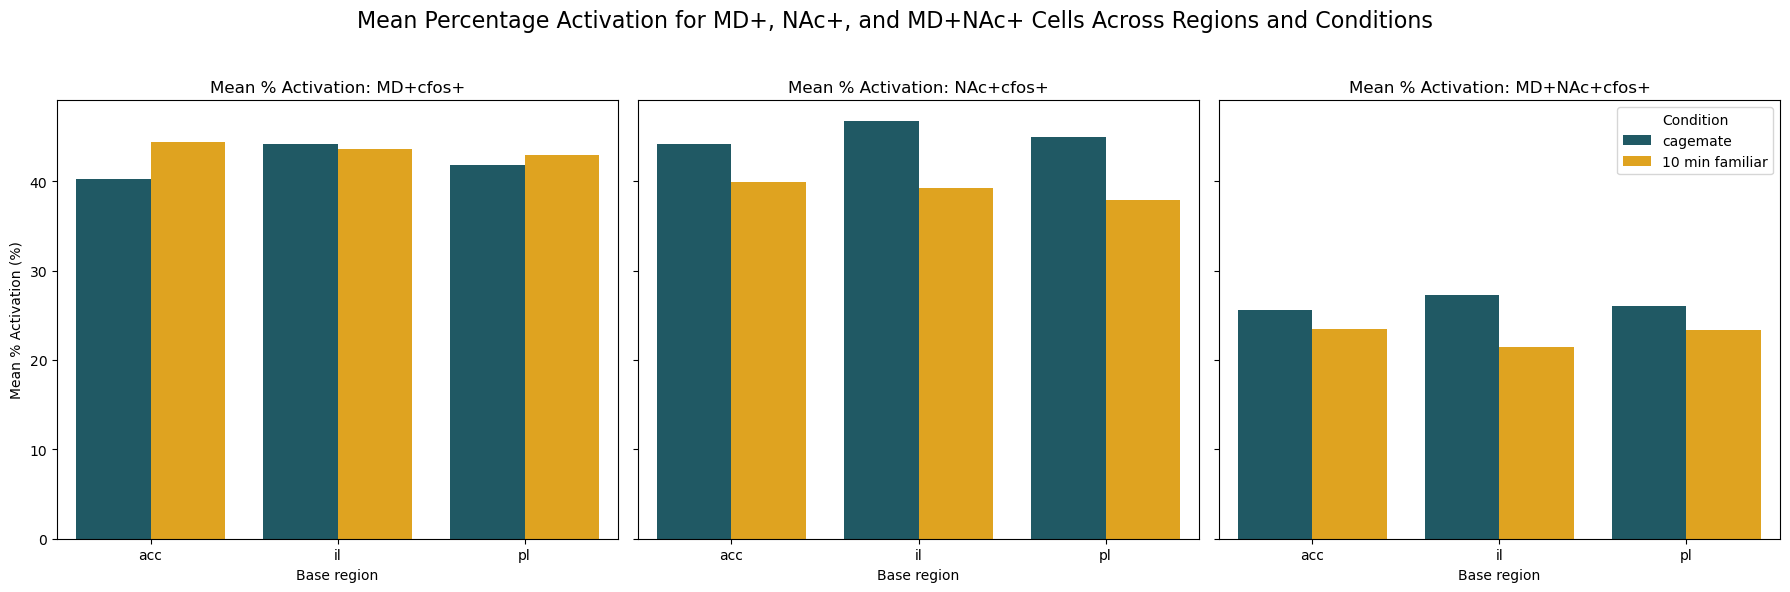

In [124]:
# Define a custom color palette
custom_palette = {'cagemate': '#FFAF00', '10min_fam': '#15616F'}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for MD+cfos+ (with corrected title)
sns.barplot(x='Base region', y='MD+cfos+_activation', hue='sheet', data=mean_activation, ax=axes[0], palette=custom_palette)
axes[0].set_title('Mean % Activation: MD+cfos+')
axes[0].set_ylabel('Mean % Activation (%)')

# Plot for NAc+cfos+ (with corrected title)
sns.barplot(x='Base region', y='NAc+cfos+_activation', hue='sheet', data=mean_activation, ax=axes[1], palette=custom_palette)
axes[1].set_title('Mean % Activation: NAc+cfos+')
axes[1].set_ylabel('')  # No y-label for the middle plot

# Plot for MD+NAc+cfos+ (with corrected title and single legend)
sns.barplot(x='Base region', y='MD+NAc+cfos+_activation', hue='sheet', data=mean_activation, ax=axes[2], palette=custom_palette)
axes[2].set_title('Mean % Activation: MD+NAc+cfos+')
axes[2].set_ylabel('')  # No y-label for the right plot

# Add a general title for the figure
fig.suptitle('Mean Percentage Activation for MD+, NAc+, and MD+NAc+ Cells Across Regions and Conditions', fontsize=16)

# Customize legend for the third subplot (axes[2])
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles, ['cagemate', '10 min familiar'], title='Condition')

# Remove legends from the first two subplots
axes[0].get_legend().remove()
axes[1].get_legend().remove()

# Adjust layout to make space for the suptitle and ensure proper alignment
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave enough space for the suptitle without overlapping
plt.show()


In [123]:
pip install --upgrade seaborn



  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---------------- ----------------------- 122.9/294.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


this is not calculating averages but total counts instead not sure what the deal is

In [ ]:
# Compute the average counts across subjects, grouped by Projector, Base region, and Sheet.
average_counts = projector_counts.groupby(['Subject', 'Projector', 'Base region', 'sheet'])['Count'].mean().reset_index()
# Renaming the 'Count' column to 'Average Count' to reflect the aggregation method.
average_counts.rename(columns={'Count': 'Total Count'}, inplace=True)
print("Average counts for each projector by base region and sheet:")
average_counts

Average counts for each projector by base region and sheet:


,Subject,Projector,Base region,sheet,Total Count
0,1_2,MD+,acc,10min_fam,694.0
1,1_2,MD+,il,10min_fam,1314.0
2,1_2,MD+,pl,10min_fam,299.0
3,1_2,MD+NAc+,acc,10min_fam,757.0
4,1_2,MD+NAc+,il,10min_fam,1462.0
...,...,...,...,...,...
163,3_3,NAc+cfos+,il,cagemate,390.0
164,3_3,NAc+cfos+,pl,cagemate,485.0
165,3_3,cfos+,acc,cagemate,231.0
166,3_3,cfos+,il,cagemate,442.0


In [ ]:
# Mean cell counts by Subject for full_focus1 (10 min fam) 
print("Mean cell counts by Subject for 10 min fam:")
print(sheet1_processed.groupby('Subject')['Count'].mean())


# Mean cell counts by Subject for full_focus2 (cagemate)
print("Mean cell counts by Subject for cagemate:")
print(sheet2_processed.groupby('Subject')['Count'].mean())
projector_mean = sheet2_processed.groupby('Projector')['Count'].mean()

Mean cell counts by Subject for 10 min fam:
Subject
1_2    269.730159
1_3    216.142857
2_1    244.285714
2_2    158.333333
2_3    240.265306
Name: Count, dtype: float64
Mean cell counts by Subject for cagemate:
Subject
3_1    149.238095
3_2    104.125000
3_3    103.792208
Name: Count, dtype: float64
